# Test German NLP Pipeline

Test NLP pipeline for dependency parsing and semantic role labeling in German. 

Requirements:
- `spacy`: >= 3.0
- `pandas`: >= 1.0
- `gensim`: >= 4.0

In [142]:
import spacy
import re
import math
import warnings
import gensim
import random
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import combinations
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [2]:
if spacy.__version__ < "3":
    warnings.warn("Module 'spacy' should be version >= 3.0 to run this notebook without errors")

In [3]:
if pd.__version__ < "1.0":
    warnings.warn("Module 'pandas' should be version >= 1.0 to run this notebook without errors")

In [4]:
if gensim.__version__ < "4.0":
    warnings.warn("Module 'gensim' should be version >= 4.0 to run this notebook without errors")

## Retrieve Stories From the Web

Build web scraper for German stories about the pandemic. The stories are published on a webpage from the HSPV NRW (University of Applied Sciences for the police and public administration) and written by students as well as staff. For a general description, see: https://www.hspv.nrw.de/services/corona-krise/corona-geschichten

In [5]:
# Define URL and story page ids

URL = "https://www.hspv.nrw.de/nachrichten/artikel/corona-geschichten"

ID_STORIES = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13"]

In [6]:
# Function to retrieve text from webpages

def get_text_from_web(url, ids):
    docs = []

    for id in ids:
        new_page = urlopen(url + "-" + id).read()

        new_soup = BeautifulSoup(new_page, 'html.parser')

        for script in new_soup(["script", "style"]):
            script.decompose()
        
        docs.append(list(new_soup.stripped_strings))
    
    return docs

  

Extract the relevant stories by removing text that is present in all documents (e.g., menu headers).

In [7]:
# Function to extract only text from stories

def extract_story_text(docs):
    new_docs = [[s for s in docs[0] if s not in docs[-1]]]

    for doc in docs[1:]:
        new_docs.append([s for s in doc if s not in docs[0]])
    
    return new_docs

Format the stories into a dictionary with keys:
- title: Title
- author: Author
- date: Date
- text: Text as single string

Also removes dash unicode and hashtags in the text.

In [8]:
# Function to format stories into dicts

def convert_stories_to_dict(docs):
    docs_dict = []
    
    for doc in docs:
        new_dict = {}
        title = doc[1]
        author = doc[3]
        date = doc[2]
        text = "".join(s + " " for s in doc[1:] if s not in [title, author, date]).replace("\xa0", "")
        docs_dict.append({
            "title": title,
            "author": author,
            "date": date,
            "text": text
        })
        
    return docs_dict

In [9]:
docs = get_text_from_web(URL, ID_STORIES)

In [10]:
short_docs = extract_story_text(docs)

dict_docs = convert_stories_to_dict(short_docs)

In [11]:
print(dict_docs[1]["text"])

Studienalltag in Zeiten von Corona Ann-Katrin Vengels, Studentin der HSPV NRW am Studienort Mülheim an der Ruhr, berichtet aus ihrem Alltag zwischen Homeschooling, Kinderbetreuung und Online-Studium. In den vergangenen Jahren habe ich die Frage nach meinem Befinden stets mit den Worten „Der normale Wahnsinn halt“ beantwortet. Und ja, irgendwie ist der Wahnsinn tatsächlich normal geworden. Ich bin Mutter von zwei Kindern, meine Tochter ist 13 und mein Sohn sechs. Seit zehn Jahren bin ich verheiratet. 2019 habe ich mich dazu entschlossen, meinen Beruf aufzugeben und mich weiterzuentwickeln, weshalb ich mich für ein duales Bachelorstudium an der HSPV entschieden habe. Mittlerweile studiere ich im zweiten Studienjahr Polizeivollzugsdienst und bin Kommissaranwärterin. Mein Ehemann (der inzwischen auch mein Kollege ist) und ich sind über die Jahre zu einem eingespielten Team geworden, das perfekt aufeinander eingestellt ist. Ein großer Pluspunkt, der definitiv eine wichtige Rolle bei meinem 

## Dependency Parsing and Named Entity Recognition

Before running the pipeline, the pipeline must be installed, e.g., via:

`python3 -m spacy download de_core_news_sm`

For details on the pipeline, see: https://spacy.io/models/de.


In [12]:
# Load german nlp pipeline trained on news documents (sm = small size)

nlp = spacy.load("de_core_news_sm")

In [13]:
def analyse_stories(docs):
    processed_docs = []
    
    for doc in docs:
        processed_docs.append(nlp(doc["text"]))
        
    return processed_docs

In [14]:
processed_docs = analyse_stories(dict_docs)

In [15]:
# From danlp_test notebook

def print_results(doc):
    analysis = []
    for token in doc:
        analysis.append({ 
            "text": token.text,
            "lemma": token.lemma_,
            "head": token.head.i,
            "dep": token.dep_,
            "pos": token.pos_,
            "morph_case": "".join(token.morph.get("Case")),
            "morph_person": "".join(token.morph.get("Person")),
            "morph_number": "".join(token.morph.get("Number")),
            "ent": token.ent_type_
        })
    return pd.DataFrame(analysis)

In [16]:
# From danlp_test notebook

def show_results(results_dict):
    results_df = pd.DataFrame([{ "key": key, "count": results_dict[key]} 
                               for key in sorted(results_dict, key=lambda k: results_dict[k], reverse=True)])
    return results_df

In [17]:
# From danlp_test notebook

def get_best_keys(results_df):
    best_count = -1
    best_keys = []
    for i, row in results_df.iterrows():
        if row["count"] > best_count:
            best_count = row["count"]
            best_keys = [row["key"]]
        elif row["count"] == best_count:
            best_keys.append(row["key"])
    case_is_upper = []
    for key in best_keys:
        case_is_upper.append(re.search(r"^[A-Z]", key) != None)
    if True in case_is_upper:
        best_keys = [ best_keys[i] for i in range(0, len(best_keys)) if case_is_upper[i] ] 
    return best_keys

In [18]:
# From danlp_test notebook

def get_actors(nlp_table_df):
    actors = {}
    for i, row in nlp_table_df.iterrows():
        if row["dep"] == "sb" and re.search("[a-zA-Z]", row["text"]):
            actor = row["text"]
        else:
            actor = ""
        if actor != "":
            if actor in actors:
                actors[actor] += 1
            else:
                actors[actor] = 1
    return actors

In [19]:
# From danlp_test notebook

def get_locations(nlp_table_df):
    locations = {}
    for i, row in nlp_table_df.iterrows():
        if row["ent"] == "LOC" and re.search("[a-zA-Z]", row["text"]):
            location = row["text"]
        else:
            location = ""
        if location != "":
            if location in locations:
                locations[location] += 1
            else:
                locations[location] = 1
    return locations

In [20]:
# From danlp_test notebook

def get_actions(nlp_table_df):
    actions = {}
    for i, row in nlp_table_df.iterrows():
        if row["pos"] == "VERB" and re.search("[a-zA-Z]", row["text"]):
            if row["lemma"] in actions:
                actions[row["lemma"]] += 1
            else:
                actions[row["lemma"]] = 1
    return actions

Calculate the type of agency in the story as the average frequency of pronouns, nouns (and proper nouns) in nominative (agent) vs. dative/accusative (object) case.

In [21]:
def calc_agency(nlp_table_df):
    agency = (nlp_table_df[nlp_table_df.morph_case.ne("") 
                           & nlp_table_df.pos.isin(["PROPN", "NOUN", "PRON"]) 
                           & nlp_table_df.morph_case.ne("Gen")]
        .assign(agent_object = lambda dataframe: np.where(dataframe["morph_case"] == "Nom", "agent", "object"))
        .groupby(["pos", "morph_person", "morph_number", "agent_object"], as_index = False)
        .agg(count = ("text", "count"))
    )
    
    return agency

In [22]:
def concatenate_results(docs, fun):
    df_list = []
    for i, doc in enumerate(docs):
        df_list.append(show_results(fun(print_results(doc))).assign(id = i+1))
    
    return pd.concat(df_list, ignore_index = True)

Sum the counts for concatenated data frames.

In [23]:
def show_top_keys(count_df_list):
    top_keys = (count_df_list
          .groupby(["key"], as_index = False)
          .agg(count = ("count", sum))
          .sort_values(by = ["count"], ascending = False)
          .head(10)  
    )
    
    return top_keys

In [24]:
def concatenate_agency(docs):
    df_list = []
    for i, doc in enumerate(docs):
        df_list.append(calc_agency(print_results(doc)).assign(id = i+1))
    
    return pd.concat(df_list)

Plot the agency for pronouns in a bar chart.

In [25]:
def plot_pronoun_agency(agency_df):
    plot_df = agency_df[agency_df.pos.eq("PRON") & agency_df.morph_number.ne("") & agency_df.morph_person.ne("")]
    
    plot = sns.catplot(
        data = plot_df,
        x = "morph_person",
        y = "count",
        hue = "agent_object",
        col ="morph_number",
        kind = "point"
    )
    
    print(plot)

In [26]:
# Show top actors from all stories

show_top_keys(concatenate_results(processed_docs, get_actors))

,key,count
203,ich,110
225,wir,52
201,es,30
66,Ich,29
210,man,19
216,sie,18
190,das,17
192,die,16
222,was,13
4,Alltag,11


The storytellers themselves seem to be the most prevalent actors ("ich"). Quite often they also act as part of a group (i.e., "wir").

In [27]:
# Show top actions from all stories

show_top_keys(concatenate_results(processed_docs, get_actions))

,key,count
174,kommen,21
149,haben,17
135,gehen,16
53,berichten,15
132,geben,14
123,finden,14
189,machen,10
180,lassen,10
313,verändern,10
241,sehen,10


Interestingly, 'changing' ("verändern") seems to be quite a prevalent action.

In [28]:
# Show top locations from all stories

show_top_keys(concatenate_results(processed_docs, get_locations))

,key,count
26,Homeoffice,9
52,Mülheim,6
63,Ruhr,4
84,der,4
83,an,4
41,Lehrveranstaltungen,4
44,Lockdown,3
9,Borken,3
35,Kreis,3
14,Corona,3


Some of the keys are not actually locations (i.e., lockdown, Corona). Apparently, spaCy's named entity recognition is not very good for German due to limited training data (e.g., see https://github.com/explosion/spaCy/issues/2774). However, "Homeoffice", "Mülheim", and "Lehrveranstaltungen" (i.e., in class) seem like very plausible locations.

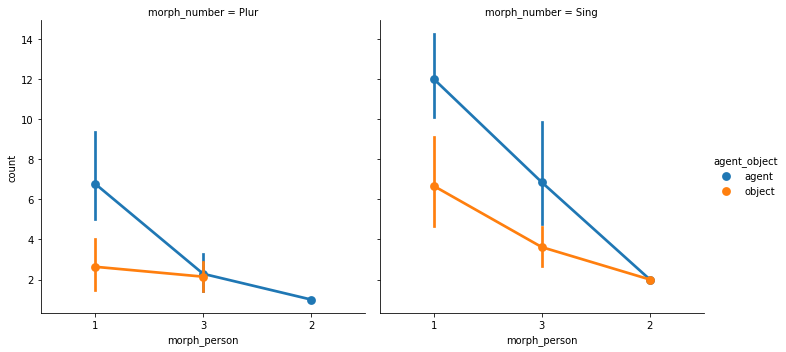

In [29]:
# Show agency across all stories

plot_pronoun_agency(concatenate_agency(processed_docs))

## Semantic Role Labeling

Only option sofar: With pre-trained tensorflow model as described in https://liir.cs.kuleuven.be/software_pages/damesrl.php. The link also contains the source code and pre-trained model files in folder `charatt_ger_march23`. The software is distributed under the Apache 2.0 license.

## Topic Modeling

Define a corpus for topic modeling that only includes lemmatized adjectives, nouns, proper nouns, and verbs.

In [30]:
# Function to create corpus for topic modeling

def create_corpus_from_processed_docs(docs):
    corpus = []

    for doc in docs:
        new_res = print_results(doc)
        new_lemma_doc = new_res.lemma[new_res.pos.isin(["ADJ", "NOUN", "PNOUN", "VERB"])]
        corpus.append(new_lemma_doc)

    return corpus

In [31]:
# Create corpus

corpus = create_corpus_from_processed_docs(processed_docs)

### Latent Dirichlet Allocation

One method for topic modeling is Latent Dirichlet Allocation (LDA; see Blei, Ng, & Jordan, 2003). In LDA, each document in a corpus is modeled as a finite mixture of topics (i.e., the number of topics is known in advance and fixed). Each topic is modeled as an infinite mixture of words (i.e., the number of words per topic is not known in advance and random). The argument `passes` specifies how often the entire corpus is passed through during training.

In [32]:
# Function to apply LDA to corpus

def apply_LDA(corpus, num_topics, seed = None):
    dictionary = corpora.Dictionary(corpus)
    
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
    
    lda_fit = LdaModel(doc_term_matrix, num_topics = NUM_TOPICS, id2word = dictionary, passes = 100, random_state = seed)
    
    return dictionary, doc_term_matrix, lda_fit

In [33]:
# Apply LDA to corpus

NUM_TOPICS = 3

SEED = 791234

dictionary, doc_term_matrix, lda_fit = apply_LDA(corpus, NUM_TOPICS, SEED)

In [34]:
# Funtion to get top word probabilities per topic as data frame

def get_top_word_probs(lda_fit, num_topics, num_words):
    top_words = lda_fit.show_topics(num_topics = num_topics, num_words = num_words, formatted = False)

    top_words_df = (pd.DataFrame(top_words)
                      .explode(1, ignore_index = True)
                      .rename(columns = {0: "topic_id", 1: "word_prob"})
                     )
    top_words_df[["word", "prob"]] = top_words_df["word_prob"].tolist()
    
    return top_words_df[["topic_id", "word", "prob"]]

In [48]:
# Function to plot top LDA word probabilities per topic

def plot_top_word_probs(lda_fit, num_topics, num_words):
    plot_df = get_top_word_probs(lda_fit, num_topics, num_words)
    
    plot = sns.catplot(
        data = plot_df,
        x = "prob",
        y = "word",
        col = "topic_id",
        hue = "topic_id",
        kind = "bar",
        sharey = False,
        col_wrap = 3
    )
    
    print(plot)

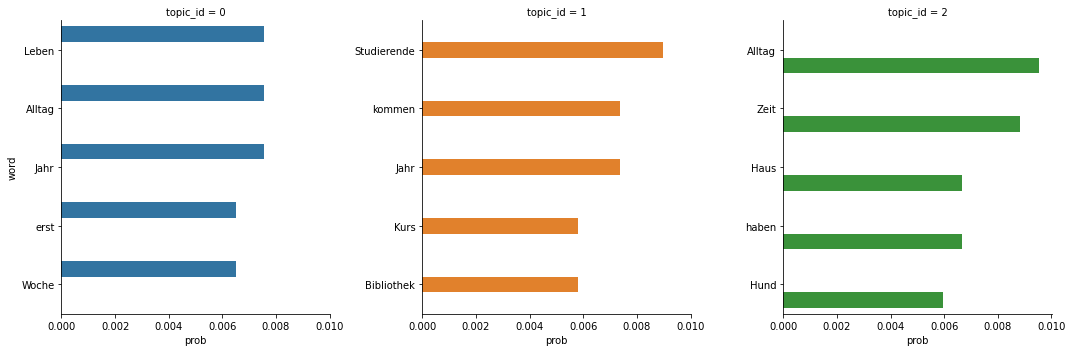

In [51]:
plot_top_word_probs(lda_fit, NUM_TOPICS, 5)

To get insight into the differences between topics, the log (base 2) of the probability ratios between two topics will be calculated for each word. For each word $w$ and topics $i$ and $j$: $$ D_{wij} = log_2\left(\frac{\beta_{wi}}{\beta_{wi}}\right),$$ where $\beta_{wi}$ is the probability that word $w$ occurs in topic $i$. For example, a $D_{wij} = 2$ would indicate that word $w$ is two times more likely to occur within topic $i$ than in topic $j$.

In [230]:
# Function to calculate the differences between topics

def get_topic_differences(lda_fit, num_topics, num_words):
    word_probs = lda_fit.get_topics()
    word_token = [dictionary.id2token[i] for i in range(len(dictionary))]
    word_probs_df = pd.DataFrame(word_probs).transpose()
    word_probs_df.insert(0, "word", word_token)
    word_probs_df = word_probs_df[word_probs_df[0].ge(0.001) & word_probs_df[1].ge(0.001) & word_probs_df[2].ge(0.001)]
    
    for c in combinations(range(NUM_TOPICS), 2):
        word_probs_df["{}-{}".format(c[0], c[1])] = np.log2(word_probs_df[c[0]]/word_probs_df[c[1]])
        
    word_probs_df = (word_probs_df
                    .drop([i for i in range(num_topics)], axis = 1)
                    .melt(id_vars = "word", var_name = "diff", value_name = "value")
                    )
                    
    word_probs_df = (word_probs_df
                    .assign(abs_value = np.abs(word_probs_df["value"]))
                    .sort_values(by = ["diff", "abs_value"], ascending = False)
                    .groupby("diff", as_index = False)
                    .head(num_words)
                    )
    
    return word_probs_df

In [243]:
# Function to plot differences between topics

def plot_topic_differences(lda_fit, num_topics, num_words):
    plot_df = get_topic_differences(lda_fit, num_topics, num_words)
    
    plot = sns.catplot(
        data = plot_df,
        x = "value",
        y = "word",
        col = "diff",
        kind = "bar",
        sharey = False,
        col_wrap = 3
    )
    
    plot.set(xlabel = "log2(prob_ratio)")
    
    return plot

C:\Users\MalteLuken\Repositories\navigating-stories\lib\site-packages\seaborn\categorical.py:3808: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


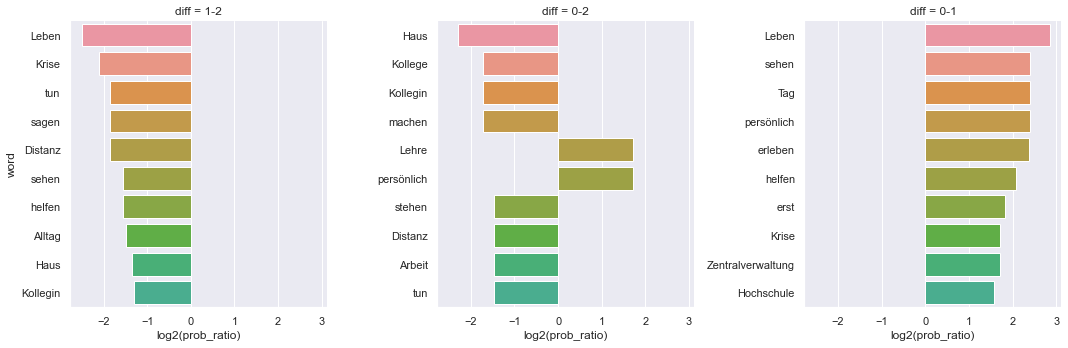

In [244]:
# Plot differences between topics

plot_topic_differences(lda_fit, NUM_TOPICS, 10)

In [37]:
# Function to get topic probabilities per document

def get_topic_probs(lda_fit, doc_term_matrix):
    doc_topic_probs = lda_fit.get_document_topics(doc_term_matrix)

    doc_topic_probs_df = pd.DataFrame({
        "doc_id": [id for id in range(len(doc_topic_probs))],
    })

    doc_topic_probs_df[["topic_id", "prob"]] = pd.DataFrame(doc_topic_probs)[0].tolist()
    
    return doc_topic_probs_df

In [38]:
# Extract topic probabilities per document

get_topic_probs(lda_fit, doc_term_matrix)

,doc_id,topic_id,prob
0,0,2.0,0.995896
1,1,1.0,0.996527
2,2,2.0,0.993872
3,3,1.0,0.997201
4,4,1.0,0.994875
5,5,2.0,0.997234
6,6,0.0,0.992656
7,7,0.0,0.995208
8,8,1.0,0.997015
9,9,0.0,0.997654


To assess the LDA models performance, the perplexity and coherence can be computed for a hold out test corpus. These measures can also be used to determine the number of topics to use in the model (i.e., lowest perplexity, highest coherence). Perplexity is purely a measure of statistical fit whereas coherence aims to indicate the interpretability by humans. There are several measures of coherence (see Röder, Both, and Hinneburg, 2015) and $C_v$ seems to perform best in most cases. However, the corpus here is too small to compute $C_v$, so $C_{UMass}$ will be used for demonstration instead.

In [39]:
# Function to evaluate the LDA model performance using hold out perplexity and coherence

def calc_LDA_performance(corpus, K, train_test_split = 0.8, seed = None):
    if seed is not None:
        random.seed(seed)
    
    dictionary = corpora.Dictionary(corpus)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
    
    doc_idx = range(len(corpus))
    train_idx = random.sample(doc_idx, k = math.floor(train_test_split*(len(corpus))))
    test_idx = [doc_idx[i] for i in doc_idx if i not in train_idx]
    train_doc_term_matrix = [doc_term_matrix[i] for i in train_idx]
    test_doc_term_matrix = [doc_term_matrix[i] for i in test_idx] if type(test_idx) is list else [doc_term_matrix[test_idx]]
    
    performance = {"k": [], "train_perplexity": [], "test_perplexity": [], "train_coherence": [], "test_coherence": []}

    for k in K: 
        train_lda_fit = LdaModel(train_doc_term_matrix, num_topics = k, id2word = dictionary, passes = 10, random_state = seed)
        train_perplexity = train_lda_fit.log_perplexity(train_doc_term_matrix)
        test_perplexity = train_lda_fit.log_perplexity(test_doc_term_matrix)
        
        performance["k"].append(k)
        performance["train_perplexity"].append(train_perplexity)
        performance["test_perplexity"].append(test_perplexity)
        
        train_coherence_model_fit = CoherenceModel(
            model = train_lda_fit,
            texts = [corpus[i] for i in train_idx],
            corpus = train_doc_term_matrix,
            dictionary = dictionary,
            coherence = "c_v"
        )
        test_coherence_model_fit = CoherenceModel(
            model = train_lda_fit,
            texts = [corpus[i] for i in test_idx] if type(test_idx) is list else corpus[test_idx],
            corpus = test_doc_term_matrix,
            dictionary = dictionary,
            coherence = "u_mass"
        )
        
        performance["train_coherence"].append(train_coherence_model_fit.get_coherence())
        performance["test_coherence"].append(test_coherence_model_fit.get_coherence())
    
    return pd.DataFrame(performance)

In [40]:
# Evaluate model performance

K = range(2, 11)

lda_performance_df = calc_LDA_performance(corpus, K, seed = SEED)

print(lda_performance_df)

    k  train_perplexity  test_perplexity  train_coherence  test_coherence
0   2         -7.186948        -9.598770         0.281702       -8.799914
1   3         -7.174706       -10.809252         0.284994       -6.989347
2   4         -7.236096       -11.715559         0.328435       -9.369097
3   5         -7.254988       -12.553841         0.316915       -8.690004
4   6         -7.299072       -13.365428         0.400858       -7.414696
5   7         -7.342455       -13.872166         0.378040       -8.549767
6   8         -7.318261       -14.803246         0.419115       -8.185515
7   9         -7.370012       -15.538190         0.390334       -7.930280
8  10         -7.287715       -16.720492         0.494777       -9.353981


In [41]:
# Function to plot model performance

def plot_lda_performance(performance_df):
    plot_df = performance_df.melt(id_vars = "k", var_name = "measure")
    plot_df[["set", "measure"]] = [s.split("_") for s in plot_df.measure]
    
    plot = sns.relplot(
        data = plot_df,
        x = "k",
        y = "value",
        row = "measure",
        style = "set",
        kind = "line",
        facet_kws = {'sharey': False, 'sharex': True}
    )
    
    return plot

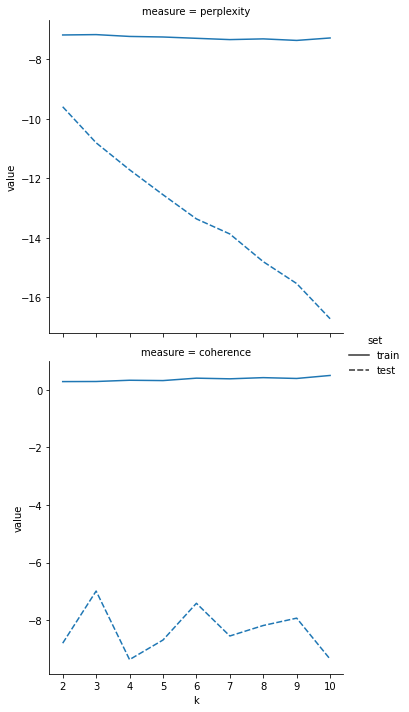

In [42]:
# Plot model performance

plot_lda_performance(lda_performance_df)

## Suggestions for Future Work

1. Look at tenses (past vs. future)
2. Look at sentiment